# <span style="color:green"><center>Prueba Tecnica Porvenir </center></span>

Una entidad bancaria desea anticipar el volumen de transacciones por operación que ocurrirán en una ventana de tiempo de 10 días. Para llevar esta tarea a cabo se cuenta con la información de las operaciones realizadas en las diferentes terminales por un periodo de 4 meses

In [8]:
pip install pandasql

In [9]:
import pandas as pd
import pandasql as ps
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import seaborn as sns
plt.style.use('ggplot')

In [ ]:
print("Versión de Tensorflow: ",tf.__version__,"\n")


Versión de Tensorflow:  2.5.0 



In [ ]:
print(np.__version__)

1.19.2


In [ ]:

# Funciones auxiliares
#
def plot_prediction(real, prediccion):
    plt.plot(real,color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

#

In [10]:
data = pd.read_csv("data_01.txt", delimiter = "\t")

**Variables que Tiene la base de Datos**

* **Fecha** :  Fecha y hora de la transacción.
* **IdTerminal**: Identificador de la terminal.
* **oper**:Tipo de operación realizada.


In [5]:
data.columns

Index(['fecha', 'idTerminal', 'oper'], dtype='object')

In [ ]:
data.head(10)

,fecha,idTerminal,oper
0,2017-01-31 08:19:33.000,1828,0
1,2017-01-31 08:47:16.000,1828,1
2,2017-01-31 08:48:07.000,1828,1
3,2017-01-31 08:48:58.000,1828,1
4,2017-01-31 08:49:53.000,1828,1
5,2017-01-31 08:51:35.000,1593,0
6,2017-01-31 08:52:45.000,1593,1
7,2017-01-31 08:53:33.000,1593,1
8,2017-01-31 08:53:53.000,1746,0
9,2017-01-31 08:54:33.000,1593,1


In [ ]:
data.tail()

,fecha,idTerminal,oper
775461,2017-05-31 23:53:06.000,1980,7
775462,2017-05-31 23:54:46.000,1980,7
775463,2017-05-31 23:57:03.000,1964,4
775464,2017-05-31 23:58:15.000,1964,0
775465,2017-05-31 23:59:48.000,1882,0


**Conocer los tipos de variables que conforma la base y la dimensión de la misma**

In [5]:
print(data.dtypes)
print()
print('Dimensión de la base :',data.shape)

fecha          object
idTerminal    float64
oper          float64
dtype: object

Dimensión de la base : (491111, 3)


**Determinar la cantidad de valores ausentes para cada variable**

In [6]:
data.isna().sum()

fecha         0
idTerminal    1
oper          1
dtype: int64

**Volumen de transacciones por Operaciones (Aquellas que presentaron mas de 1000)**

In [11]:
ope_vol=ps.sqldf("""select   oper as Operaciones, count(*) as Volumen_transacciones
                  from data
                  group by oper
                  order by Volumen_transacciones desc
                        """)

In [12]:
porcen=100 * data['oper'].value_counts() / len(data['oper'])
porcen=pd.DataFrame(porcen)
porcen= porcen.reset_index()
porcen.columns=['oper','trans']

In [13]:
ope_vol=ps.sqldf("""select   a.*, b.trans as Vol_tran_porce
                  from     ope_vol a 
                  left join porcen b
                  on a.Operaciones=b.oper                    
          """)


In [14]:
ope_vol.head()

,Operaciones,Volumen_transacciones,Vol_tran_porce
0,0,423929,54.667645
1,3,127399,16.428702
2,1,79195,10.212569
3,7,50662,6.533104
4,4,35817,4.618771


In [ ]:
ope_vol.shape

(46, 3)

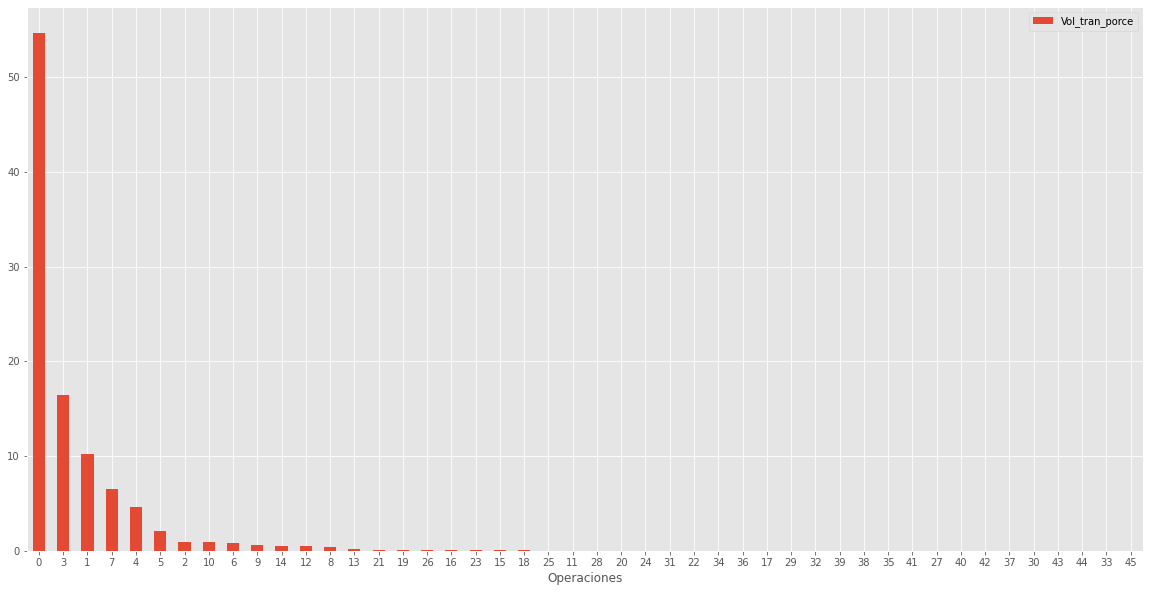

In [16]:
# Distribucion del volumen transaccional por operacion
ax = ope_vol.plot.bar(x='Operaciones', y='Vol_tran_porce', rot=0,figsize=(20,10))

**Volumen de transacciones por Terminal**

In [18]:
ter_vol=ps.sqldf("""select   idTerminal as Terminal, count(*) as Volumen_transacciones
            from     data
            group by idTerminal
            order by Volumen_transacciones desc
                        """)

In [ ]:
data.shape

(775466, 3)

In [19]:
porcen=100 * data['idTerminal'].value_counts() / len(data['idTerminal'])
porcen=pd.DataFrame(porcen)
porcen= porcen.reset_index()
porcen.columns=['idTerminal','trans']

In [20]:
ter_vol=ps.sqldf("""select   a.*, b.trans as Vol_tran_porce
                  from     ter_vol a 
                  left join porcen b
                  on a.Terminal=b.idTerminal                    
          """)

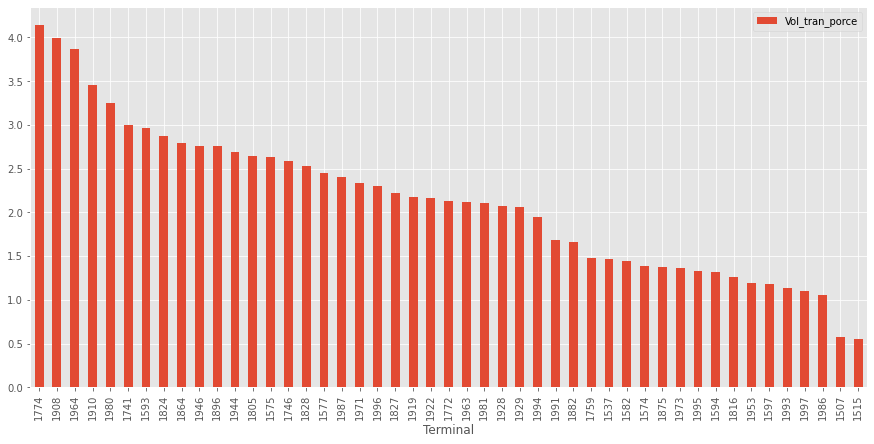

In [23]:
# Distribucion del volumen transaccional por terminal
vt = ter_vol.plot.bar(x='Terminal', y='Vol_tran_porce',figsize=(15,7))

In [ ]:
ter_vol.shape

(47, 3)

In [13]:
ter_vol.head()

,Terminal,Volumen_transacciones,Vol_tran_porce
0,1908.0,20942,4.264209
1,1964.0,20464,4.166879
2,1774.0,19911,4.054277
3,1963.0,16429,3.345272
4,1910.0,16395,3.338349


Como se quiere entender el volumen de transacciones por operación y por terminal, se genera la tabla Ter_ope que mira el volumen transaccional por operacion y terminal. 

In [32]:
Ter_ope=ps.sqldf("""select   idTerminal, oper as Operacion,count(*) as Volumen_transacciones
            from     data 
            group by idTerminal, oper
            order by Volumen_transacciones desc 
            """)

In [35]:
Ter_ope.head()

,idTerminal,Operacion,Volumen_transacciones
0,1774,0,17790
1,1910,0,16395
2,1908,0,15868
3,1964,0,15620
4,1577,0,13628


In [70]:
ps.sqldf("""select   distinct (Operacion), idTerminal , Volumen_transacciones
                 from     Ter_ope
                               """)

,Operacion,idTerminal,Volumen_transacciones
0,0,1774,17790
1,0,1910,16395
2,0,1908,15868
3,0,1964,15620
4,0,1577,13628
...,...,...,...
1291,17,1995,1
1292,27,1996,1
1293,40,1996,1
1294,43,1996,1


In [63]:
#Ter_ope['Operacion']!=0
a=(Ter_ope['Operacion']!=0) & (Ter_ope['idTerminal']!=1774)
b=(Ter_ope['Operacion']!=3) & (Ter_ope['idTerminal']!=1964)
c=(Ter_ope['Operacion']!=1) & (Ter_ope['idTerminal']!=1980)
d=(Ter_ope['Operacion']!=4) & (Ter_ope['idTerminal']!=1908)
Ter_ope[a & b & c & d]



,idTerminal,Operacion,Volumen_transacciones
77,1910,7,2279
80,1864,7,2154
105,1981,7,1794
107,1944,7,1766
108,1996,7,1762
...,...,...,...
1291,1995,17,1
1292,1996,27,1
1293,1996,40,1
1294,1996,43,1


In [21]:
# Tabla de conteos doble entrada
# pd.crosstab(index=data['idTerminal'],columns=data['oper'], margins=True)

# Tabla de doble entrada pero en porcentaje
ab=pd.crosstab(index=data[filtro].idTerminal,columns=data[filtro].oper, margins=False).apply(lambda r: r/len(data)*100,axis=1)
type(ab)

pandas.core.frame.DataFrame

In [ ]:
#  Se determina el quantil 0.8 del volumen de las transacciones con el fin de obtener las operaciones
#  que presentaron mas volumen.

print(Ter_ope['Volumen_transacciones'].quantile(q=0.8)/len(data)*100)
print(Ter_ope['Volumen_transacciones'].quantile(q=0.80))

0.04203923834184864
326.0


In [16]:
# Se determina las terminales y operaciones que  presentaron un volumen mayor a 326.

a=Ter_ope[Ter_ope['Volumen_transacciones']>326].idTerminal.unique()
b=Ter_ope[Ter_ope['Volumen_transacciones']>326].Operacion.unique()


In [17]:
##  Se determina el filtro 

filtro=[]
for i in range(len(data)):
  filtro.append(data['oper'][i] in b)

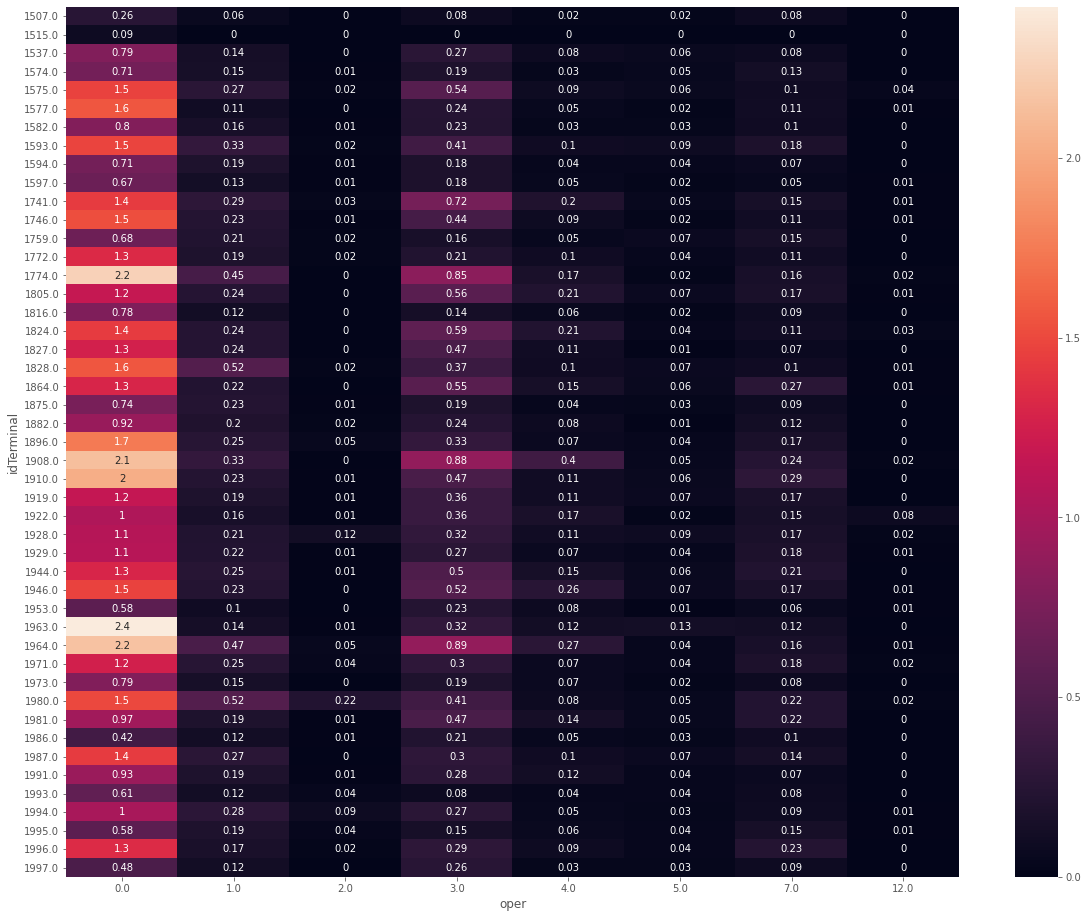

In [22]:
# se representa el volumen transaccional por operacion y terminal.
plt.figure(figsize=(20,16))
sns.heatmap(round(ab,2), annot=True)

In [ ]:
Ter_ope.shape

(1296, 3)

**Selección de las 5 terminales y 5 operaciones que presentaron mayor volumen transaccional**

| Terminal | Operación |
|:--------:|:---------:|
|   1774   |     0     |
|   1964   |     3     |
|   1980   |     1     |
|   1908   |     4     |
|   1910   |     7     |

In [64]:
prueba=ps.sqldf("""select   fecha,idTerminal,oper
            from     data 
            where idTerminal=1774 and oper=0
                  """)

In [65]:
prueba_2=ps.sqldf("""select   fecha,idTerminal,oper
            from     data 
            where idTerminal=1964 and oper=3
                  """)

In [66]:
prueba_3=ps.sqldf("""select   fecha,idTerminal,oper
            from     data 
            where idTerminal=1980 and oper=1
                  """)

In [67]:
prueba_4=ps.sqldf("""select   fecha,idTerminal,oper
            from     data 
            where idTerminal=1908 and oper=4
                  """)

In [68]:
prueba_5=ps.sqldf("""select   fecha,idTerminal,oper
            from     data 
            where idTerminal=1910 and oper=7
                  """)

In [ ]:
print(prueba.dtypes)

fecha         object
idTerminal     int64
oper           int64
dtype: object


In [ ]:
prueba.head()

,fecha,idTerminal,oper
0,2017-01-31 21:04:58.000,1774,0
1,2017-01-31 21:10:42.000,1774,0
2,2017-01-31 21:11:22.000,1774,0
3,2017-01-31 21:12:58.000,1774,0
4,2017-01-31 22:24:34.000,1774,0


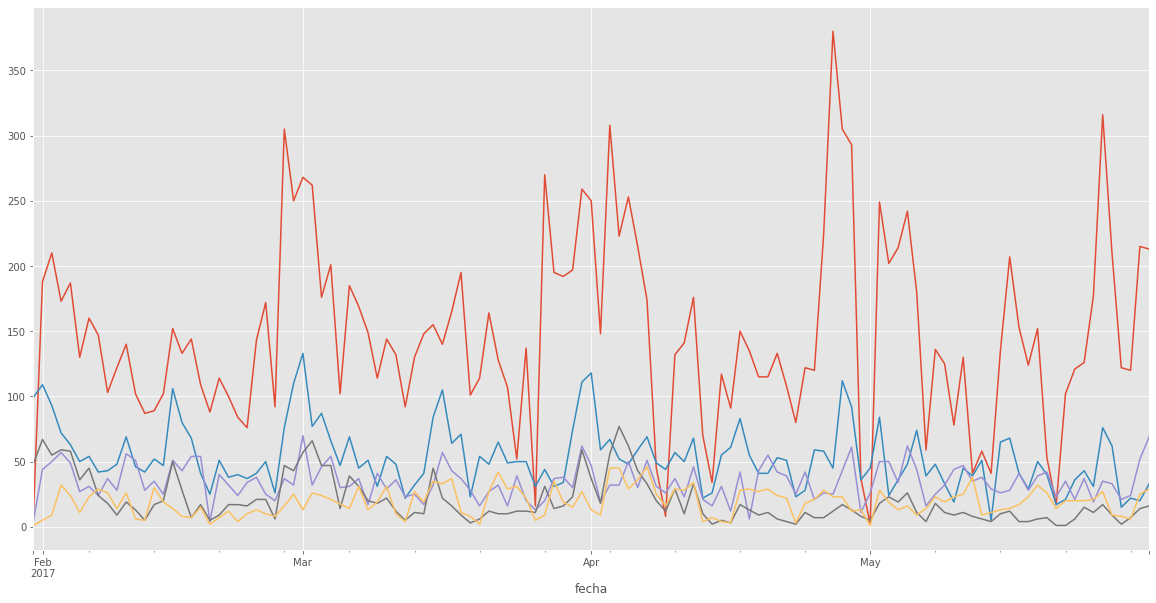

In [69]:
prueba['fecha'] = pd.to_datetime(prueba['fecha'])
monthly_orders = prueba.groupby(prueba['fecha'].dt.to_period('D')).size()
monthly_orders.plot.line(figsize=(20,10))

prueba_2['fecha'] = pd.to_datetime(prueba_2['fecha'])
monthly_orders = prueba_2.groupby(prueba_2['fecha'].dt.to_period('D')).size()
monthly_orders.plot.line(figsize=(20,10))

prueba_3['fecha'] = pd.to_datetime(prueba_3['fecha'])
monthly_orders = prueba_3.groupby(prueba_3['fecha'].dt.to_period('D')).size()
monthly_orders.plot.line(figsize=(20,10))

prueba_4['fecha'] = pd.to_datetime(prueba_4['fecha'])
monthly_orders = prueba_4.groupby(prueba_4['fecha'].dt.to_period('D')).size()
monthly_orders.plot.line(figsize=(20,10))

prueba_5['fecha'] = pd.to_datetime(prueba_5['fecha'])
monthly_orders = prueba_5.groupby(prueba_5['fecha'].dt.to_period('D')).size()
monthly_orders.plot.line(figsize=(20,10))

In [ ]:
prueba.shape

(17790, 3)

**Visualización del volumen transaccional Terminal 1774 operacion 0**

Text(0.5, 1.0, 'Terminal 1774 operacion 0')

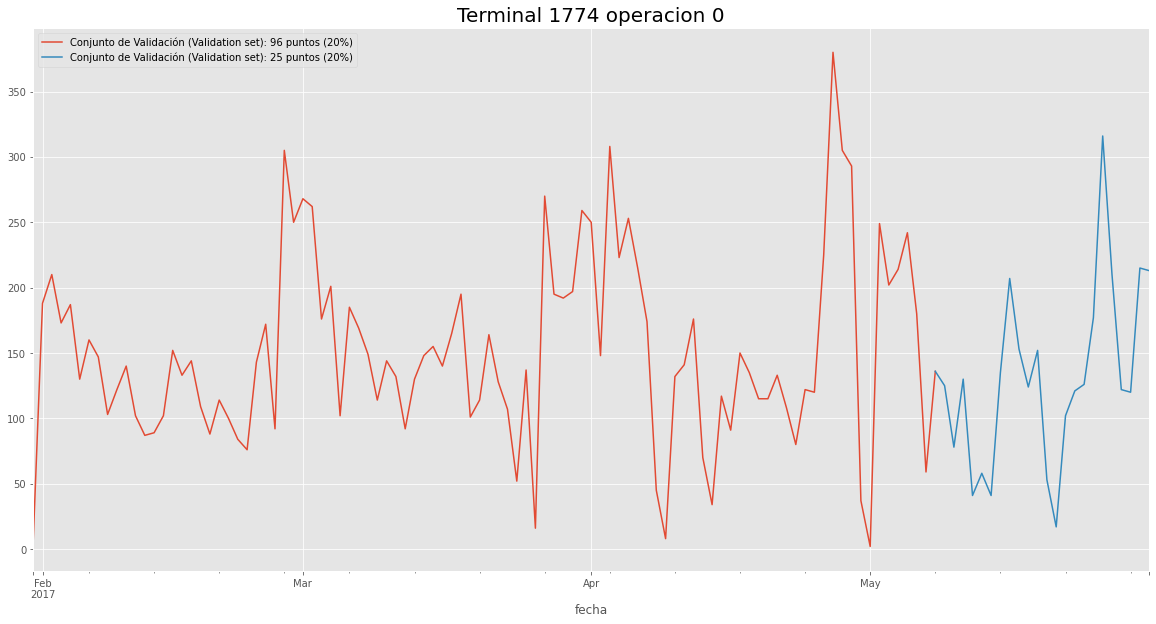

In [ ]:
monthly_orders[:98].plot.line(figsize=(20,10),label='Conjunto de Validación (Validation set): 96 puntos (20%)')
monthly_orders[97:].plot.line(figsize=(20,10), label='Conjunto de Validación (Validation set): 25 puntos (20%)')
plt.legend()
plt.title("Terminal 1774 operacion 0", size = 20)

## Ajuste del modelo Arima

In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from pylab import rcParams


In [72]:
prueba['fecha'] = pd.to_datetime(prueba['fecha'])
monthly_orders = prueba.groupby(prueba['fecha'].dt.to_period('D')).size()
d = { 'fecha': monthly_orders.index, 'Volum_tra':monthly_orders.values}
df = pd.DataFrame(data=d)

In [73]:
from datetime import datetime
#df['fecha'].map.(lambda x: x.strftime("%Y-%m-%d "))
a=map(lambda x: x.strftime("%Y-%m-%d "), df['fecha'])
df['fecha']=list(a)

### Visualización de la Serie

Text(0.5, 1.0, 'Terminal 1774 operacion 0')

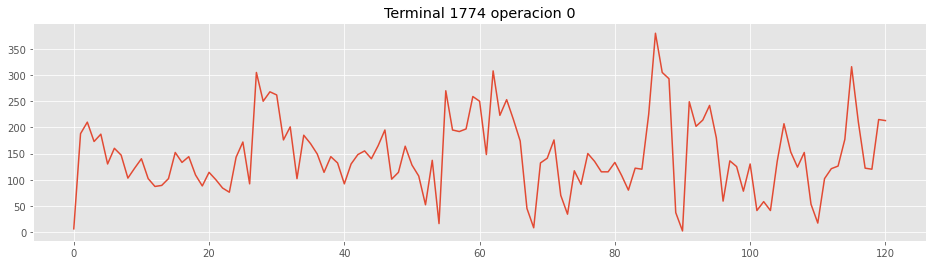

In [78]:
rcParams['figure.figsize'] = 16, 4
plt.plot(df['Volum_tra'])
plt.title('Terminal 1774 operacion 0')

Como se puede apreciar en la grafica la serie no presenta tendencia y tanto  la media y la varianza permanece constante a lo largo del tiempo.

Para justificar las anteriores afirmaciones se procede a realizar la prueba  de Dickey-Fuller.

In [79]:
result = adfuller(df['Volum_tra'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -6.810255980704882
p-value: 2.1252135997147925e-09
Critical Values:
	1%: -3.486055829282407
	5%: -2.8859430324074076
	10%: -2.5797850694444446


Se obtiene un p-valor cercano a cero, asi que se rechaza la hipotesis nula. obteniendo que los datos son estacionarios y no se hace necesario diferenciar la serie. 

### ACF y PACF 

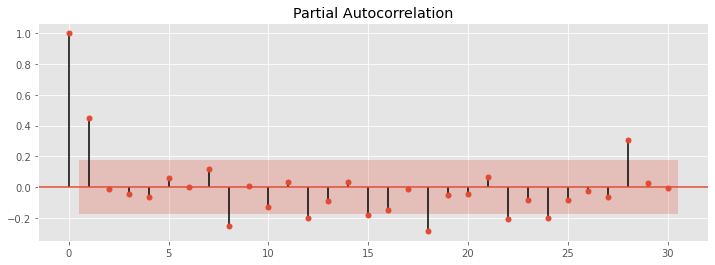

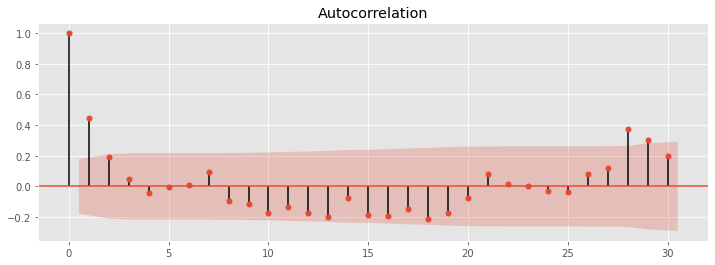

In [84]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
rcParams['figure.figsize'] = 12, 4
plot_pacf(df['Volum_tra'],lags=30)
plot_acf(df['Volum_tra'],lags=30)
plt.show()

Observando la función de autocorrelación se puede apreciar que el primer rezago es significativo y que no hay estacionalidad.

Con la función de autocorrelación parcial se aprecian rezagos significativos en $h=1, h=8, h=12$ y $h=18$.

Asi, los posibles valores para un modelo $ARMA(p,q)$ son $p=1,2$ y $q= 1,8,12$ y $18$

Se ajusta un modelo ARIMA (18,0,1)

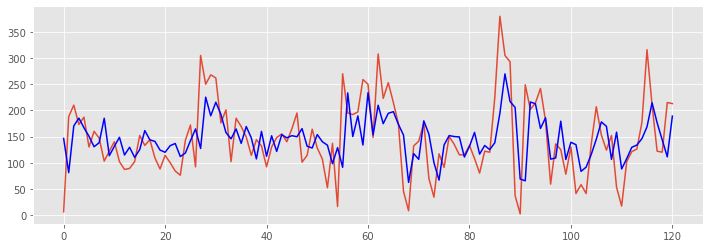

In [89]:
model_1 = ARIMA(df['Volum_tra'], order=(8,0,1))
model_fit_1 = model_1.fit()
plt.plot(df['Volum_tra'])
plt.plot(model_fit_1.fittedvalues, color='blue')

In [86]:
print(model_fit.summary())


                              ARMA Model Results                              
Dep. Variable:              Volum_tra   No. Observations:                  121
Model:                     ARMA(8, 1)   Log Likelihood                -668.778
Method:                       css-mle   S.D. of innovations             60.583
Date:                Tue, 20 Jul 2021   AIC                           1359.555
Time:                        04:33:11   BIC                           1390.309
Sample:                             0   HQIC                          1372.045
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             146.4123      9.553     15.326      0.000     127.688     165.136
ar.L1.Volum_tra     0.0643      0.468      0.137      0.891      -0.853       0.982
ar.L2.Volum_tra     0.2000      

In [87]:
print(sum((df['Volum_tra']-model_fit.fittedvalues)**2))

451365.3867950319


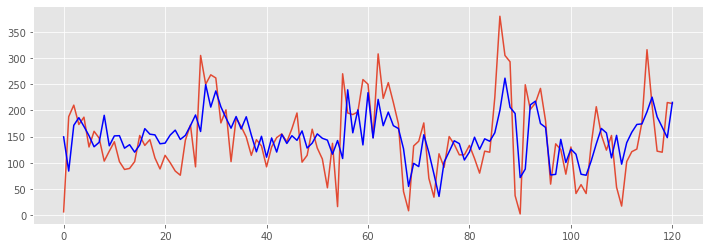

In [90]:
model_2 = ARIMA(df['Volum_tra'], order=(8,0,2))
model_fit_2 = model_2.fit()
plt.plot(df['Volum_tra'])
plt.plot(model_fit_2.fittedvalues, color='blue')

In [92]:
print(sum((df['Volum_tra']-model_fit_2.fittedvalues)**2))

414948.9350143868


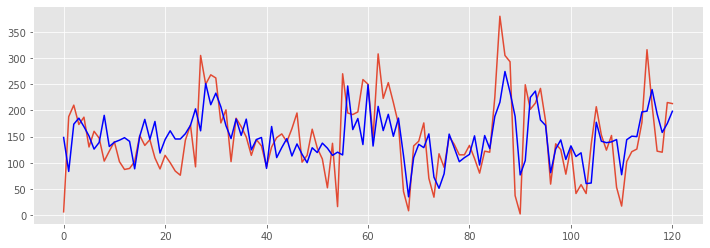

In [93]:
model_3 = ARIMA(df['Volum_tra'], order=(18,0,2))
model_fit_3 = model_3.fit()
plt.plot(df['Volum_tra'])
plt.plot(model_fit_3.fittedvalues, color='blue')

In [94]:
print(sum((df['Volum_tra']-model_fit_3.fittedvalues)**2))

378267.2466994767


Teniendo en cuenta el error cuadratico medio de los anteriores modelos, se elige el modelo 3 para realizar el pronostico a 10 dias.

In [104]:
df.tail()

,fecha,Volum_tra
116,2017-05-27,210
117,2017-05-28,122
118,2017-05-29,120
119,2017-05-30,215
120,2017-05-31,213


In [116]:
 start_index = datetime(2017, 6, 1)
 datetime.timestamp(start_index)

1496275200.0

In [117]:
# multi-step out-of-sample forecast
forecast = model_fit_3.forecast(steps=10)[0]

In [130]:
prono=np.round(forecast, 0)

In [132]:
import pandas as pd
from datetime import datetime

fechas = pd.date_range(start="2017-06-01",end="2017-06-10")
d = {'fecha': fechas, 'Volumen_Transacciones': prono}
df = pd.DataFrame(data=d)
df
#future = pd.DataFrame(fechas,prono)
#future

,fecha,Volumen_Transacciones
0,2017-06-01,223.0
1,2017-06-02,255.0
2,2017-06-03,160.0
3,2017-06-04,128.0
4,2017-06-05,147.0
5,2017-06-06,178.0
6,2017-06-07,144.0
7,2017-06-08,150.0
8,2017-06-09,166.0
9,2017-06-10,138.0
